## 8.12　勾配降下法


In [1]:
# !pip install japanize_matplotlib | tail -n 1
# !pip install torchviz | tail -n 1
# !pip install torchinfo | tail -n 1

In [2]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import japanize_matplotlib
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torchviz import make_dot
from torchinfo import summary
from tqdm.notebook import tqdm
from IPython.display import display
from sklearn.datasets import load_iris
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [3]:
%matplotlib inline

In [4]:
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['axes.grid'] = True
np.set_printoptions(suppress=True, precision=4)

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [6]:
data_root = './data'
train_set0 = datasets.MNIST(root=data_root, train=True, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 193116714.56it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 92048399.56it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 79714739.81it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22359775.55it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [7]:
!ls -lR ./data/MNIST

./data/MNIST:
total 4
drwxr-xr-x 2 root root 4096 Mar 13 06:48 raw

./data/MNIST/raw:
total 65008
-rw-r--r-- 1 root root  7840016 Mar 13 06:48 t10k-images-idx3-ubyte
-rw-r--r-- 1 root root  1648877 Mar 13 06:48 t10k-images-idx3-ubyte.gz
-rw-r--r-- 1 root root    10008 Mar 13 06:48 t10k-labels-idx1-ubyte
-rw-r--r-- 1 root root     4542 Mar 13 06:48 t10k-labels-idx1-ubyte.gz
-rw-r--r-- 1 root root 47040016 Mar 13 06:48 train-images-idx3-ubyte
-rw-r--r-- 1 root root  9912422 Mar 13 06:48 train-images-idx3-ubyte.gz
-rw-r--r-- 1 root root    60008 Mar 13 06:48 train-labels-idx1-ubyte
-rw-r--r-- 1 root root    28881 Mar 13 06:48 train-labels-idx1-ubyte.gz


In [8]:
print('データ件数: ', len(train_set0))
image, label = train_set0[0]
print('入力データの型: ', type(image))
print('正解データの方: ', type(label))


データ件数:  60000
入力データの型:  <class 'PIL.Image.Image'>
正解データの方:  <class 'int'>


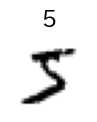

In [9]:
plt.figure(figsize=(1, 1))
plt.title(f'{label}')
plt.imshow(image, cmap='gray_r')
plt.axis('off')
plt.show()

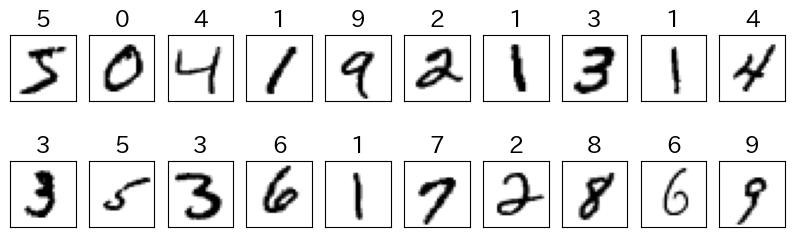

In [10]:
plt.figure(figsize=(10, 3))
for i in range(20):
  ax = plt.subplot(2, 10, i+1)

  image, label = train_set0[i]

  plt.imshow(image, cmap='gray_r')
  ax.set_title(f'{label}')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

In [11]:
transform1 = transforms.Compose([transforms.ToTensor(),])
train_set1 = datasets.MNIST(root=data_root, train=True, download=True, transform=transform1)

In [12]:
image, label = train_set1[0]
print('入力データの型: ', type(image))
print('入力データのshape: ', image.shape)
print('最小値: ', image.data.min())
print('最大値: ', image.data.max())

入力データの型:  <class 'torch.Tensor'>
入力データのshape:  torch.Size([1, 28, 28])
最小値:  tensor(0.)
最大値:  tensor(1.)


In [13]:
transform2 = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0.5, 0.5),])
train_set2 = datasets.MNIST(root=data_root, train=True, download=True, transform=transform2)

In [14]:
image, label = train_set2[0]
print('shape: ', image.shape)
print('最小値: ', image.data.min())
print('最大値: ', image.data.max())

shape:  torch.Size([1, 28, 28])
最小値:  tensor(-1.)
最大値:  tensor(1.)


In [15]:
transform3 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.Lambda(lambda x: x.view(-1)),
    ])

train_set3 = datasets.MNIST(root=data_root, train=True, download=True, transform=transform3)

In [16]:
image, label = train_set3[0]
print('shape: ', image.shape)
print('最小値: ', image.data.min())
print('最大値: ', image.data.max())

shape:  torch.Size([784])
最小値:  tensor(-1.)
最大値:  tensor(1.)


In [17]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.Lambda(lambda x: x.view(-1)),
])

train_set = datasets.MNIST(root=data_root, train=True, download=True, transform=transform)
test_set = datasets.MNIST(root=data_root, train=False, download=True, transform=transform)

In [18]:
batch_size = 500
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [19]:
print(len(train_loader))
for images, labels in train_loader:
  break

print(images.shape)
print(labels.shape)

120
torch.Size([500, 784])
torch.Size([500])


In [20]:
n_input = image.shape[0]
n_output = 10
n_hidden = 128
print(f'n_input: {n_input} n_hidden: {n_hidden} n_output: {n_output}')

n_input: 784 n_hidden: 128 n_output: 10


In [21]:
class Net(nn.Module):
  def __init__(self, n_input, n_output, n_hidden):
    super().__init__()

    self.l1 = nn.Linear(n_input, n_hidden)
    self.l2 = nn.Linear(n_hidden, n_output)
    self.relu = nn.ReLU(inplace=True)

  def forward(self, x):
    x1 = self.l1(x)
    x2 = self.relu(x1)
    x3 = self.l2(x2)
    return x3

In [22]:
torch.manual_seed(123)
torch.cuda.manual_seed(123)

net = Net(n_input, n_output, n_hidden)
net = net.to(device)

In [23]:
lr = 0.01
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [24]:
for parameters in net.named_parameters():
  print(parameters)

('l1.weight', Parameter containing:
tensor([[-0.0146,  0.0012, -0.0177,  ...,  0.0277,  0.0200,  0.0315],
        [ 0.0184, -0.0322,  0.0175,  ...,  0.0089, -0.0028, -0.0033],
        [ 0.0092,  0.0261,  0.0075,  ...,  0.0061,  0.0267, -0.0258],
        ...,
        [ 0.0235, -0.0026, -0.0129,  ...,  0.0322, -0.0059, -0.0169],
        [-0.0328, -0.0258,  0.0124,  ..., -0.0049,  0.0006,  0.0334],
        [ 0.0187, -0.0076, -0.0202,  ...,  0.0325, -0.0159, -0.0240]],
       device='cuda:0', requires_grad=True))
('l1.bias', Parameter containing:
tensor([ 0.0325, -0.0298,  0.0013,  0.0199,  0.0268, -0.0248, -0.0172, -0.0355,
         0.0122, -0.0048,  0.0214,  0.0202, -0.0243,  0.0015, -0.0276,  0.0296,
         0.0341, -0.0228,  0.0230,  0.0347, -0.0091, -0.0346,  0.0206, -0.0060,
         0.0329,  0.0047,  0.0180,  0.0101,  0.0177, -0.0309,  0.0228, -0.0224,
         0.0321,  0.0179,  0.0321,  0.0184,  0.0219, -0.0089,  0.0310, -0.0039,
        -0.0074, -0.0317,  0.0192, -0.0021,  0.0190

In [25]:
print(net)

Net(
  (l1): Linear(in_features=784, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)


In [26]:
summary(net, (784,))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [10]                      --
├─Linear: 1-1                            [128]                     100,480
├─ReLU: 1-2                              [128]                     --
├─Linear: 1-3                            [10]                      1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
Total mult-adds (M): 12.87
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.41
Estimated Total Size (MB): 0.41

In [27]:
for images, labels in train_loader:
  break

In [28]:
inputs = images.to(device)
labels = labels.to(device)

In [29]:
outputs = net(inputs)
print(outputs)

tensor([[-0.3622, -0.1927, -0.0179,  ...,  0.1073,  0.1025, -0.0615],
        [-0.4072, -0.1814,  0.0716,  ...,  0.1866,  0.1975,  0.1161],
        [-0.3221, -0.0547, -0.2868,  ...,  0.1967, -0.0103,  0.1591],
        ...,
        [-0.2091, -0.1058,  0.2365,  ...,  0.1360,  0.0665,  0.0987],
        [-0.2756, -0.2012,  0.1703,  ...,  0.1223,  0.2388,  0.0233],
        [-0.3045, -0.2458,  0.1416,  ...,  0.1012,  0.0820, -0.1457]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


2.3328874111175537


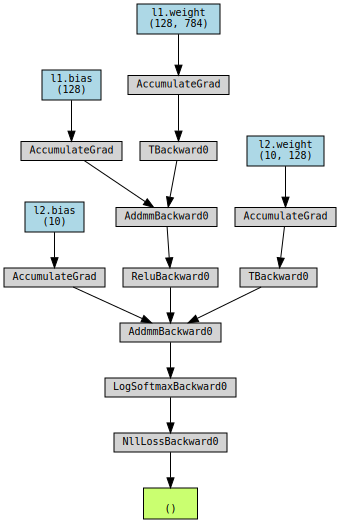

In [30]:
loss = criterion(outputs, labels)
print(loss.item())
make_dot(loss, params=dict(net.named_parameters()))

`summary()` を実行していないと、結果が変わるので注意する。

In [31]:
loss.backward()

In [32]:
w = net.to('cpu')
print(w.l1.weight.grad.numpy().shape)
print(w.l1.bias.grad.numpy().shape)
print(w.l2.weight.grad.numpy().shape)
print(w.l2.bias.grad.numpy().shape)

(128, 784)
(128,)
(10, 128)
(10,)


In [33]:
optimizer.step()

In [34]:
print(net.l1.weight)
print(net.l1.bias)

Parameter containing:
tensor([[-0.0146,  0.0012, -0.0177,  ...,  0.0278,  0.0200,  0.0316],
        [ 0.0183, -0.0322,  0.0174,  ...,  0.0088, -0.0029, -0.0034],
        [ 0.0092,  0.0261,  0.0075,  ...,  0.0061,  0.0267, -0.0258],
        ...,
        [ 0.0235, -0.0026, -0.0129,  ...,  0.0323, -0.0059, -0.0169],
        [-0.0329, -0.0258,  0.0124,  ..., -0.0049,  0.0006,  0.0334],
        [ 0.0187, -0.0076, -0.0202,  ...,  0.0325, -0.0159, -0.0240]],
       requires_grad=True)
Parameter containing:
tensor([ 3.2475e-02, -2.9682e-02,  1.2742e-03,  1.9874e-02,  2.6836e-02,
        -2.4759e-02, -1.7201e-02, -3.5517e-02,  1.2199e-02, -4.7449e-03,
         2.1379e-02,  2.0187e-02, -2.4297e-02,  1.4928e-03, -2.7613e-02,
         2.9618e-02,  3.4051e-02, -2.2777e-02,  2.2983e-02,  3.4580e-02,
        -9.1870e-03, -3.4619e-02,  2.0599e-02, -6.0632e-03,  3.2937e-02,
         4.7784e-03,  1.7949e-02,  1.0102e-02,  1.7700e-02, -3.0853e-02,
         2.2817e-02, -2.2391e-02,  3.2049e-02,  1.7890e-0

In [35]:
torch.manual_seed(123)
torch.cuda.manual_seed(123)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

lr = 0.01
net = Net(n_input, n_output, n_hidden).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr)
num_epochs = 100
history = np.zeros((0, 5))

In [36]:
for epoch in range(num_epochs):
  n_train_acc, n_val_acc = 0, 0
  train_loss, val_loss = 0, 0
  n_train, n_test = 0, 0

  for inputs, labels in tqdm(train_loader):
    train_batch_size = len(labels)
    n_train += train_batch_size

    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    predicted = torch.max(outputs, 1)[1]
    train_loss += loss.item() * train_batch_size
    n_train_acc += (predicted == labels).sum().item()

  for inputs_test, labels_test in test_loader:
    test_batch_size = len(labels_test)
    n_test += test_batch_size

    inputs_test = inputs_test.to(device)
    labels_test = labels_test.to(device)

    outputs_test = net(inputs_test)
    loss_test = criterion(outputs_test, labels_test)

    predicted_test = torch.max(outputs_test, 1)[1]
    val_loss += loss_test.item() * test_batch_size
    n_val_acc += (predicted_test == labels_test).sum().item()

  train_acc = n_train_acc / n_train
  val_acc = n_val_acc / n_test

  ave_train_loss = train_loss / n_train
  ave_val_loss = val_loss / n_test

  print(f'Epoch [{epoch+1}/{num_epochs}], loss: {ave_train_loss:.5f} acc: {train_acc:.5f} val_loss: {ave_val_loss:.5f} val_acc: {val_acc:.5f}')
  item = np.array([epoch+1, ave_train_loss, train_acc, ave_val_loss, val_acc])
  history = np.vstack((history, item))

  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [1/100], loss: 1.82932 acc: 0.56958 val_loss: 1.32629 val_acc: 0.74660


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [2/100], loss: 1.03888 acc: 0.79537 val_loss: 0.79661 val_acc: 0.83180


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [3/100], loss: 0.70809 acc: 0.84110 val_loss: 0.60256 val_acc: 0.85850


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [4/100], loss: 0.57300 acc: 0.86057 val_loss: 0.51192 val_acc: 0.87140


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [5/100], loss: 0.50223 acc: 0.87102 val_loss: 0.45827 val_acc: 0.87920


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [6/100], loss: 0.45883 acc: 0.87878 val_loss: 0.42422 val_acc: 0.88650


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [7/100], loss: 0.42938 acc: 0.88327 val_loss: 0.40076 val_acc: 0.88970


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [8/100], loss: 0.40813 acc: 0.88743 val_loss: 0.38285 val_acc: 0.89370


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [9/100], loss: 0.39176 acc: 0.89065 val_loss: 0.36857 val_acc: 0.89680


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [10/100], loss: 0.37876 acc: 0.89313 val_loss: 0.35741 val_acc: 0.89930


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [11/100], loss: 0.36812 acc: 0.89592 val_loss: 0.34868 val_acc: 0.90160


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [12/100], loss: 0.35910 acc: 0.89783 val_loss: 0.34089 val_acc: 0.90220


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [13/100], loss: 0.35147 acc: 0.89977 val_loss: 0.33336 val_acc: 0.90490


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [14/100], loss: 0.34477 acc: 0.90135 val_loss: 0.32806 val_acc: 0.90570


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [15/100], loss: 0.33860 acc: 0.90310 val_loss: 0.32334 val_acc: 0.90710


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [16/100], loss: 0.33333 acc: 0.90412 val_loss: 0.31807 val_acc: 0.90790


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [17/100], loss: 0.32843 acc: 0.90520 val_loss: 0.31445 val_acc: 0.90930


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [18/100], loss: 0.32380 acc: 0.90700 val_loss: 0.31076 val_acc: 0.91090


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [19/100], loss: 0.31950 acc: 0.90807 val_loss: 0.30586 val_acc: 0.91190


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [20/100], loss: 0.31587 acc: 0.90905 val_loss: 0.30281 val_acc: 0.91240


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [21/100], loss: 0.31199 acc: 0.91032 val_loss: 0.29965 val_acc: 0.91520


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [22/100], loss: 0.30842 acc: 0.91098 val_loss: 0.29713 val_acc: 0.91430


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [23/100], loss: 0.30507 acc: 0.91195 val_loss: 0.29432 val_acc: 0.91570


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [24/100], loss: 0.30190 acc: 0.91320 val_loss: 0.29123 val_acc: 0.91770


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [25/100], loss: 0.29883 acc: 0.91403 val_loss: 0.28884 val_acc: 0.91700


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [26/100], loss: 0.29597 acc: 0.91492 val_loss: 0.28646 val_acc: 0.91820


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [27/100], loss: 0.29311 acc: 0.91662 val_loss: 0.28365 val_acc: 0.91950


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [28/100], loss: 0.29027 acc: 0.91698 val_loss: 0.28185 val_acc: 0.92000


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [29/100], loss: 0.28765 acc: 0.91798 val_loss: 0.28041 val_acc: 0.91950


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [30/100], loss: 0.28510 acc: 0.91858 val_loss: 0.27748 val_acc: 0.92110


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [31/100], loss: 0.28233 acc: 0.91958 val_loss: 0.27485 val_acc: 0.92180


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [32/100], loss: 0.27989 acc: 0.92040 val_loss: 0.27255 val_acc: 0.92120


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [33/100], loss: 0.27763 acc: 0.92067 val_loss: 0.27010 val_acc: 0.92210


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [34/100], loss: 0.27513 acc: 0.92102 val_loss: 0.26897 val_acc: 0.92410


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [35/100], loss: 0.27278 acc: 0.92242 val_loss: 0.26668 val_acc: 0.92430


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [36/100], loss: 0.27048 acc: 0.92280 val_loss: 0.26462 val_acc: 0.92360


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [37/100], loss: 0.26828 acc: 0.92358 val_loss: 0.26279 val_acc: 0.92440


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [38/100], loss: 0.26597 acc: 0.92403 val_loss: 0.26075 val_acc: 0.92550


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [39/100], loss: 0.26357 acc: 0.92455 val_loss: 0.25918 val_acc: 0.92580


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [40/100], loss: 0.26157 acc: 0.92565 val_loss: 0.25719 val_acc: 0.92660


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [41/100], loss: 0.25919 acc: 0.92603 val_loss: 0.25558 val_acc: 0.92630


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [42/100], loss: 0.25715 acc: 0.92695 val_loss: 0.25282 val_acc: 0.92720


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [43/100], loss: 0.25496 acc: 0.92765 val_loss: 0.25100 val_acc: 0.92940


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [44/100], loss: 0.25292 acc: 0.92775 val_loss: 0.24995 val_acc: 0.92800


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [45/100], loss: 0.25096 acc: 0.92845 val_loss: 0.24743 val_acc: 0.92930


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [46/100], loss: 0.24867 acc: 0.92937 val_loss: 0.24636 val_acc: 0.93070


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [47/100], loss: 0.24664 acc: 0.92965 val_loss: 0.24402 val_acc: 0.93100


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [48/100], loss: 0.24463 acc: 0.93042 val_loss: 0.24264 val_acc: 0.93060


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [49/100], loss: 0.24266 acc: 0.93060 val_loss: 0.24012 val_acc: 0.93220


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [50/100], loss: 0.24070 acc: 0.93147 val_loss: 0.23928 val_acc: 0.93250


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [51/100], loss: 0.23872 acc: 0.93212 val_loss: 0.23708 val_acc: 0.93300


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [52/100], loss: 0.23680 acc: 0.93225 val_loss: 0.23567 val_acc: 0.93290


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [53/100], loss: 0.23485 acc: 0.93345 val_loss: 0.23360 val_acc: 0.93310


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [54/100], loss: 0.23294 acc: 0.93442 val_loss: 0.23177 val_acc: 0.93430


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [55/100], loss: 0.23101 acc: 0.93478 val_loss: 0.22988 val_acc: 0.93460


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [56/100], loss: 0.22909 acc: 0.93517 val_loss: 0.22863 val_acc: 0.93460


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [57/100], loss: 0.22729 acc: 0.93568 val_loss: 0.22641 val_acc: 0.93600


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [58/100], loss: 0.22537 acc: 0.93643 val_loss: 0.22547 val_acc: 0.93580


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [59/100], loss: 0.22367 acc: 0.93693 val_loss: 0.22324 val_acc: 0.93600


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [60/100], loss: 0.22190 acc: 0.93743 val_loss: 0.22190 val_acc: 0.93630


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [61/100], loss: 0.22019 acc: 0.93808 val_loss: 0.22011 val_acc: 0.93690


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [62/100], loss: 0.21845 acc: 0.93840 val_loss: 0.21884 val_acc: 0.93770


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [63/100], loss: 0.21653 acc: 0.93903 val_loss: 0.21656 val_acc: 0.93720


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [64/100], loss: 0.21485 acc: 0.93970 val_loss: 0.21577 val_acc: 0.93910


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [65/100], loss: 0.21321 acc: 0.94003 val_loss: 0.21334 val_acc: 0.93830


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [66/100], loss: 0.21152 acc: 0.94050 val_loss: 0.21216 val_acc: 0.93890


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [67/100], loss: 0.20996 acc: 0.94112 val_loss: 0.21143 val_acc: 0.93960


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [68/100], loss: 0.20826 acc: 0.94157 val_loss: 0.20924 val_acc: 0.94000


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [69/100], loss: 0.20673 acc: 0.94210 val_loss: 0.20716 val_acc: 0.94000


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [70/100], loss: 0.20500 acc: 0.94235 val_loss: 0.20682 val_acc: 0.94000


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [71/100], loss: 0.20353 acc: 0.94292 val_loss: 0.20485 val_acc: 0.94080


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [72/100], loss: 0.20198 acc: 0.94355 val_loss: 0.20380 val_acc: 0.94120


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [73/100], loss: 0.20053 acc: 0.94373 val_loss: 0.20211 val_acc: 0.94110


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [74/100], loss: 0.19892 acc: 0.94420 val_loss: 0.20087 val_acc: 0.94240


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [75/100], loss: 0.19754 acc: 0.94453 val_loss: 0.19895 val_acc: 0.94270


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [76/100], loss: 0.19587 acc: 0.94513 val_loss: 0.19793 val_acc: 0.94270


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [77/100], loss: 0.19454 acc: 0.94533 val_loss: 0.19671 val_acc: 0.94330


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [78/100], loss: 0.19313 acc: 0.94565 val_loss: 0.19520 val_acc: 0.94430


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [79/100], loss: 0.19163 acc: 0.94620 val_loss: 0.19405 val_acc: 0.94430


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [80/100], loss: 0.19041 acc: 0.94635 val_loss: 0.19304 val_acc: 0.94360


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [81/100], loss: 0.18891 acc: 0.94713 val_loss: 0.19190 val_acc: 0.94340


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [82/100], loss: 0.18764 acc: 0.94737 val_loss: 0.19039 val_acc: 0.94470


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [83/100], loss: 0.18620 acc: 0.94795 val_loss: 0.18892 val_acc: 0.94570


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [84/100], loss: 0.18487 acc: 0.94812 val_loss: 0.18786 val_acc: 0.94500


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [85/100], loss: 0.18358 acc: 0.94818 val_loss: 0.18690 val_acc: 0.94610


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [86/100], loss: 0.18228 acc: 0.94888 val_loss: 0.18556 val_acc: 0.94620


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [87/100], loss: 0.18101 acc: 0.94955 val_loss: 0.18461 val_acc: 0.94570


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [88/100], loss: 0.17976 acc: 0.94977 val_loss: 0.18364 val_acc: 0.94700


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [89/100], loss: 0.17846 acc: 0.95025 val_loss: 0.18184 val_acc: 0.94720


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [90/100], loss: 0.17737 acc: 0.95042 val_loss: 0.18089 val_acc: 0.94730


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [91/100], loss: 0.17612 acc: 0.95097 val_loss: 0.17952 val_acc: 0.94780


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [92/100], loss: 0.17488 acc: 0.95118 val_loss: 0.17919 val_acc: 0.94800


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [93/100], loss: 0.17383 acc: 0.95140 val_loss: 0.17744 val_acc: 0.94810


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [94/100], loss: 0.17264 acc: 0.95175 val_loss: 0.17635 val_acc: 0.94810


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [95/100], loss: 0.17143 acc: 0.95218 val_loss: 0.17556 val_acc: 0.94890


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [96/100], loss: 0.17035 acc: 0.95275 val_loss: 0.17470 val_acc: 0.94810


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [97/100], loss: 0.16915 acc: 0.95272 val_loss: 0.17389 val_acc: 0.94830


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [98/100], loss: 0.16811 acc: 0.95332 val_loss: 0.17414 val_acc: 0.94830


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [99/100], loss: 0.16696 acc: 0.95357 val_loss: 0.17145 val_acc: 0.94830


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [100/100], loss: 0.16583 acc: 0.95408 val_loss: 0.17067 val_acc: 0.94960
